In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.preprocessing import LabelEncoder
from imblearn.over_sampling import RandomOverSampler

from sklearn.model_selection import train_test_split

from transformers import DistilBertTokenizer
from transformers import TFDistilBertForSequenceClassification
from transformers import TextClassificationPipeline

import tensorflow as tf
from sklearn.metrics import confusion_matrix, classification_report
import json
import gc

import re
import nltk
from nltk.corpus import stopwords
nltk.download('stopwords')
stopw = stopwords.words('english')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


# 1. Processing and Cleaning

In [51]:
df1 = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/article/articles.csv',encoding='latin1')
df1.head()

,Id,Heading,Article.Banner.Image,Outlets,Article.Description,Full_Article,Article_Type,Tonality
0,d6995462-5e87-453b-b64d-e9f1df6e94d2,"A Puzzling Maneuver, Then Freefall: NTSB Repor...",NaN,Essex Caller,<p>The helicopter that crashed in Southeast Al...,<p>The helicopter that crashed in Southeast Al...,Commercial,Negative
1,8b05e939-a89e-4548-b92b-013822e8ee7d,Bells Nexus Air Taxi Concept Rings Changes Fo...,NaN,Aviation Week Network,<p>A year after teasing the fledgling electric...,<p>A year after teasing the fledgling electric...,Commercial,Positive
2,69fcd400-bceb-4255-8277-619f2d68ac0b,Bell Helicopter Show Air Taxi Nexus,http://images.tmtpost.com/uploads/images/2019/...,TMTPost,<p>Bell released the full-size design of the v...,<p>Bell released the full-size design of the v...,Commercial,Positive
3,17943578-c11b-414b-b3f5-063d3a93157b,BELL DÉVOILE LA CONCEPTION INTÉGRALE DE SON TA...,http://www.fredzone.org/wp-content/uploads/201...,Fredzone,<p>Bell est une soci&eacute;t&eacute; am&eacut...,<p>Bell est une soci&eacute;t&eacute; am&eacut...,Commercial,Positive
4,f33c7b11-5f77-4a98-bb2e-d36689042aea,Les premiers retours dOlivier Ezratty,NaN,FrenchWeb,<p>It was still anecdotal to observe the explo...,<p>It was still anecdotal to observe the explo...,Commercial,Positive


In [52]:
df = df1[['Heading', 'Article.Description', 'Full_Article', 'Tonality', 'Outlets','Article_Type']]
df.head()
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4305 entries, 0 to 4304
Data columns (total 6 columns):
 #   Column               Non-Null Count  Dtype 
---  ------               --------------  ----- 
 0   Heading              4305 non-null   object
 1   Article.Description  4305 non-null   object
 2   Full_Article         4305 non-null   object
 3   Tonality             3873 non-null   object
 4   Outlets              4305 non-null   object
 5   Article_Type         4305 non-null   object
dtypes: object(6)
memory usage: 201.9+ KB


In [53]:
missing_values = df.isna().sum()
missing_values


Heading                  0
Article.Description      0
Full_Article             0
Tonality               432
Outlets                  0
Article_Type             0
dtype: int64

In [54]:
df = df.dropna()
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 3873 entries, 0 to 4303
Data columns (total 6 columns):
 #   Column               Non-Null Count  Dtype 
---  ------               --------------  ----- 
 0   Heading              3873 non-null   object
 1   Article.Description  3873 non-null   object
 2   Full_Article         3873 non-null   object
 3   Tonality             3873 non-null   object
 4   Outlets              3873 non-null   object
 5   Article_Type         3873 non-null   object
dtypes: object(6)
memory usage: 211.8+ KB


In [55]:
df['Article_Type'].unique()

array(['Commercial', 'Military', 'Training', 'Others', 'Financing',
       'Support & Services', 'Executives'], dtype=object)

In [56]:
label_encoder = LabelEncoder()
df['Article_Type'] = label_encoder.fit_transform(df['Article_Type'])

In [57]:
mapping = {label_encoder.classes_[i]: i for i in range(len(label_encoder.classes_))}
print(mapping)

{'Commercial': 0, 'Executives': 1, 'Financing': 2, 'Military': 3, 'Others': 4, 'Support & Services': 5, 'Training': 6}


# Counting number of words in Full_article

In [58]:
df['count'] = df['Full_Article'].apply(lambda x: len(x.split()))
df.head()

,Heading,Article.Description,Full_Article,Tonality,Outlets,Article_Type,count
0,"A Puzzling Maneuver, Then Freefall: NTSB Repor...",<p>The helicopter that crashed in Southeast Al...,<p>The helicopter that crashed in Southeast Al...,Negative,Essex Caller,0,55
1,Bells Nexus Air Taxi Concept Rings Changes Fo...,<p>A year after teasing the fledgling electric...,<p>A year after teasing the fledgling electric...,Positive,Aviation Week Network,0,68
2,Bell Helicopter Show Air Taxi Nexus,<p>Bell released the full-size design of the v...,<p>Bell released the full-size design of the v...,Positive,TMTPost,0,35
3,BELL DÉVOILE LA CONCEPTION INTÉGRALE DE SON TA...,<p>Bell est une soci&eacute;t&eacute; am&eacut...,<p>Bell est une soci&eacute;t&eacute; am&eacut...,Positive,Fredzone,0,56
4,Les premiers retours dOlivier Ezratty,<p>It was still anecdotal to observe the explo...,<p>It was still anecdotal to observe the explo...,Positive,FrenchWeb,0,39


<Figure size 800x800 with 0 Axes>

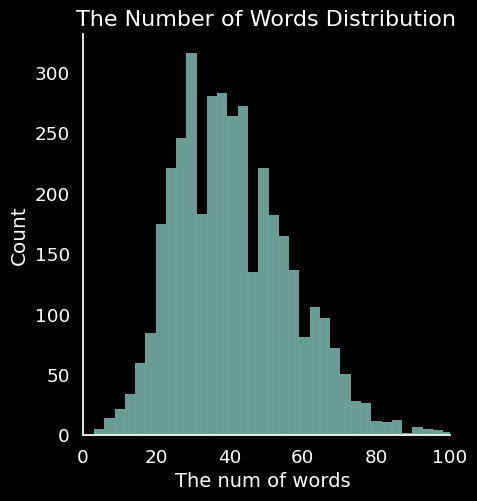

In [59]:
plt.figure(figsize= (8, 8))
plt.style.use('dark_background')

sns.displot(df['count'])

plt.xlim(0, 100)
plt.grid(False)

plt.xlabel('The num of words ', fontsize = 14)

plt.title("The Number of Words Distribution", fontsize = 16)
plt.show()

# Text Cleaning

In [60]:
import re

def clean_text(text):
    cleanr = re.compile('<.*?>')
    cleantext = re.sub(cleanr, '', text)
    clean_text = re.sub(r'[^a-zA-Z0-9\s]', '', cleantext)

    return clean_text.strip()

In [61]:
df['Full_Article'] = df['Full_Article'].apply(lambda x: clean_text(x))
df['Article.Description'] = df['Article.Description'].apply(lambda x: clean_text(str(x)))
df['Heading'] = df['Heading'].apply(lambda x: clean_text(str(x)))
df.head()


,Heading,Article.Description,Full_Article,Tonality,Outlets,Article_Type,count
0,A Puzzling Maneuver Then Freefall NTSB Report ...,The helicopter that crashed in Southeast Alask...,The helicopter that crashed in Southeast Alask...,Negative,Essex Caller,0,55
1,Bells Nexus Air Taxi Concept Rings Changes For...,A year after teasing the fledgling electric ve...,A year after teasing the fledgling electric ve...,Positive,Aviation Week Network,0,68
2,Bell Helicopter Show Air Taxi Nexus,Bell released the fullsize design of the verti...,Bell released the fullsize design of the verti...,Positive,TMTPost,0,35
3,BELL DVOILE LA CONCEPTION INTGRALE DE SON TAXI...,Bell est une socieacuteteacute ameacutericaine...,Bell est une socieacuteteacute ameacutericaine...,Positive,Fredzone,0,56
4,Les premiers retours dOlivier Ezratty,It was still anecdotal to observe the explosio...,It was still anecdotal to observe the explosio...,Positive,FrenchWeb,0,39


In [62]:
df['Article_Type'].value_counts()

Article_Type
0    2235
3    1492
1      59
4      52
5      26
2       7
6       2
Name: count, dtype: int64

In [63]:
X = df.drop('Article_Type', axis=1)
y = df['Article_Type']

oversampler = RandomOverSampler(random_state=42)
X_resampled, y_resampled = oversampler.fit_resample(X, y)

df_resampled = pd.DataFrame(X_resampled, columns=X.columns)
df_resampled['Article_Type'] = y_resampled


print(df_resampled['Article_Type'].value_counts())


Article_Type
0    2235
3    2235
6    2235
4    2235
2    2235
5    2235
1    2235
Name: count, dtype: int64


In [64]:
data_texts = df_resampled['Full_Article'].to_list()
data_labels = df_resampled['Article_Type'].to_list()

# Train Test Split

In [65]:
train_texts, val_texts, train_labels, val_labels = train_test_split(data_texts, data_labels, test_size = 0.2, random_state = 0 )


train_texts, test_texts, train_labels, test_labels = train_test_split(train_texts, train_labels, test_size = 0.01, random_state = 0 )

In [66]:
 Test_df = pd.DataFrame({ 'text': test_texts,
                          'label': test_labels
                      })

 Test_df

,text,label
0,The results for the first nine months are summ...,2
1,quotRevenues were lower in the quarter largely...,2
2,Airbus Helicopters will add a new Maintenance ...,4
3,This announcement comes as Airbus continues to...,1
4,Moving to Bell profits were up in the quarter ...,2
...,...,...
121,A new training facility was opened with a ribb...,6
122,It39s the first time a first lady has ever flo...,6
123,We also recently read a story on the HTC VIVE ...,4
124,Mr Faury took over the commercial plane unit w...,1


# vectorization

In [18]:
from transformers import DistilBertTokenizer

tokenizer = DistilBertTokenizer.from_pretrained('distilbert-base-uncased')

train_encodings = tokenizer(train_texts, truncation = True, padding = True  )

val_encodings = tokenizer(val_texts, truncation = True, padding = True )

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:81: UserWarning: 
Access to the secret `HF_TOKEN` has not been granted on this notebook.
You will not be requested again.
Please restart the session if you want to be prompted again.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

/usr/local/lib/python3.10/dist-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


config.json:   0%|          | 0.00/483 [00:00<?, ?B/s]

In [19]:
train_dataset = tf.data.Dataset.from_tensor_slices((
    dict(train_encodings),
    train_labels
))


val_dataset = tf.data.Dataset.from_tensor_slices((
    dict(val_encodings),
    val_labels
))

print("train_dataset and val_dataset ready")


train_dataset and val_dataset ready


In [20]:
train_dataset.element_spec

({'input_ids': TensorSpec(shape=(512,), dtype=tf.int32, name=None),
  'attention_mask': TensorSpec(shape=(512,), dtype=tf.int32, name=None)},
 TensorSpec(shape=(), dtype=tf.int32, name=None))

In [21]:
for batch in train_dataset.take(1):
    print(batch)

({'input_ids': <tf.Tensor: shape=(512,), dtype=int32, numpy=
array([  101, 16360,  9152,  2696, 14086,  2100,  2097,  3497,  7868,
        1996,  3472,  9650,  1997,  1996,  2440,  2837,  2096, 16360,
       10905, 18203,  2099,  1037,  2067,  2121,  1997,  2107,  3454,
        2004,  1996,  4330,  5092, 12377,  2290,  1058, 19317,  9808,
       28139,  2100,  1998,  1996,  4330,  6289,  2487,  2480, 17947,
        2097,  2507,  2039,  2014,  3472,  9650,  1997,  5292, 19797,
        3497,  2000, 16360,  2848, 25292, 20464,  2891,  4801,  1996,
        2783,  5464,  2266,  1997,  1996,  5292,  2278, 18052,  2006,
        3639,  4330,  2038,  4128,  1999,  3481,  4276,  1998, 23204,
       10486,  3146,   102,     0,     0,     0,     0,     0,     0,
           0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,     0,  

## Model Creation


In [22]:
model = TFDistilBertForSequenceClassification.from_pretrained('distilbert-base-uncased', num_labels=5)

optimizer = tf.keras.optimizers.Adam(learning_rate=5e-5, epsilon=1e-08)

model.compile(optimizer=optimizer,
              loss=model.hf_compute_loss,
              metrics=['accuracy'])

model.safetensors:   0%|          | 0.00/268M [00:00<?, ?B/s]

Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFDistilBertForSequenceClassification: ['vocab_transform.weight', 'vocab_projector.bias', 'vocab_transform.bias', 'vocab_layer_norm.weight', 'vocab_layer_norm.bias']
- This IS expected if you are initializing TFDistilBertForSequenceClassification from a PyTorch model trained on another task or with another architecture (e.g. initializing a TFBertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFDistilBertForSequenceClassification from a PyTorch model that you expect to be exactly identical (e.g. initializing a TFBertForSequenceClassification model from a BertForSequenceClassification model).
Some weights or buffers of the TF 2.0 model TFDistilBertForSequenceClassification were not initialized from the PyTorch model and are newly initialized: ['pre_classifier.weight', 'pre_classifier.bias', 'classifier.weight', 'classifier.bias']
You should 

In [23]:
from tensorflow.keras.callbacks import EarlyStopping

early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)

model.fit(train_dataset.shuffle(1000).batch(16),
          epochs=5,
          batch_size=16,
          validation_data=val_dataset.shuffle(1000).batch(16),
          callbacks=[early_stopping])

# Display the model's architecture
model.summary()

Epoch 1/5


Cause: for/else statement not yet supported
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


Cause: for/else statement not yet supported
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
775/775 [==============================] - 742s 888ms/step - loss: nan - accuracy: 0.1449 - val_loss: nan - val_accuracy: 0.1352
Epoch 2/5
775/775 [==============================] - 680s 877ms/step - loss: nan - accuracy: 0.1449 - val_loss: nan - val_accuracy: 0.1352
Epoch 3/5
775/775 [==============================] - 683s 882ms/step - loss: nan - accuracy: 0.1449 - val_loss: nan - val_accuracy: 0.1352
Model: "tf_distil_bert_for_sequence_classification"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 distilbert (TFDistilBertMa  multiple                  66362880  
 inLayer)                                                        
                                                                 
 pre_classifier (Dense)      multiple                  590592    
       

## Saving the Model



In [24]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [25]:
save_directory = "/content/drive/MyDrive/Colab Notebooks/article"

model.save_pretrained(save_directory)
tokenizer.save_pretrained(save_directory)

('/content/drive/MyDrive/Colab Notebooks/article/tokenizer_config.json',
 '/content/drive/MyDrive/Colab Notebooks/article/special_tokens_map.json',
 '/content/drive/MyDrive/Colab Notebooks/article/vocab.txt',
 '/content/drive/MyDrive/Colab Notebooks/article/added_tokens.json')

# Loading the model

In [26]:
from tensorflow.keras.models import load_model
from transformers import DistilBertTokenizer
from transformers import TFDistilBertForSequenceClassification
from transformers import TextClassificationPipeline

save_directory = "/content/drive/MyDrive/Colab Notebooks/article"

In [27]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [28]:
loaded_tokenizer = DistilBertTokenizer.from_pretrained(save_directory)

loaded_model = TFDistilBertForSequenceClassification.from_pretrained(save_directory)

print("\n\n** Model Loaded Sucessfully **")

Some layers from the model checkpoint at /content/drive/MyDrive/Colab Notebooks/article were not used when initializing TFDistilBertForSequenceClassification: ['dropout_19']
- This IS expected if you are initializing TFDistilBertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFDistilBertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some layers of TFDistilBertForSequenceClassification were not initialized from the model checkpoint at /content/drive/MyDrive/Colab Notebooks/article and are newly initialized: ['dropout_39']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.




** Model Loaded Sucessfully **


## Validate and evaluate the Accuracy

In [33]:
mapping = {
    0: 'Commercial',
    1: 'Executives',
    2: 'Financing',
    3: 'Military',
    4: 'Others',
    5: 'Support & Services',
    6: 'Training'
}

In [34]:
test_texts = Test_df['text'].to_list()

# Initialize lists to store predictions
predicted_texts = []
predicted_labels = []

# Iterate through each text
for text in test_texts:
    # Encode text using loaded tokenizer
    predict_input = loaded_tokenizer.encode(text,
                                            truncation=True,
                                            padding=True,
                                            return_tensors="tf")

    # Make prediction using loaded model
    output = loaded_model(predict_input)[0]
    prediction_value = tf.argmax(output, axis=1).numpy()[0]

    # Append results to lists
    predicted_texts.append(text)
    predicted_labels.append(prediction_value)

# Map predicted labels to categories using mapping dictionary
predicted_categories = [mapping[label] for label in predicted_labels]

# Create DataFrame to store predictions
prediction_df = pd.DataFrame({
    'text': predicted_texts,
    'predicted_label': predicted_labels,
    'predicted_category': predicted_categories
})

# Display the DataFrame with predictions
prediction_df

,text,predicted_label,predicted_category
0,The results for the first nine months are summ...,0,Commercial
1,quotRevenues were lower in the quarter largely...,0,Commercial
2,Airbus Helicopters will add a new Maintenance ...,0,Commercial
3,This announcement comes as Airbus continues to...,0,Commercial
4,Moving to Bell profits were up in the quarter ...,0,Commercial
...,...,...,...
121,A new training facility was opened with a ribb...,0,Commercial
122,It39s the first time a first lady has ever flo...,0,Commercial
123,We also recently read a story on the HTC VIVE ...,0,Commercial
124,Mr Faury took over the commercial plane unit w...,0,Commercial


#  performance metrics

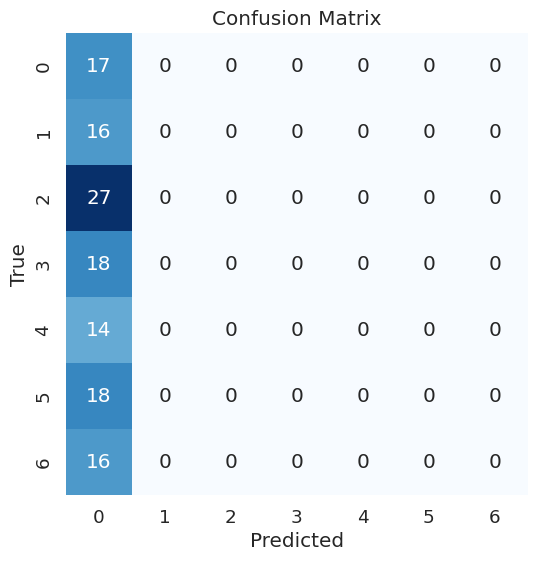

In [44]:
confusion = confusion_matrix(test_labels, predicted_labels)

plt.figure(figsize=(8, 6))
sns.set(font_scale=1.2)
sns.heatmap(confusion, annot=True, fmt="d", cmap="Blues", cbar=False, square=True)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

In [45]:
print(classification_report(test_labels, predicted_labels))

              precision    recall  f1-score   support

           0       0.13      1.00      0.24        17
           1       0.00      0.00      0.00        16
           2       0.00      0.00      0.00        27
           3       0.00      0.00      0.00        18
           4       0.00      0.00      0.00        14
           5       0.00      0.00      0.00        18
           6       0.00      0.00      0.00        16

    accuracy                           0.13       126
   macro avg       0.02      0.14      0.03       126
weighted avg       0.02      0.13      0.03       126



/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
